In [46]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Evitar warnings de plot inline em alguns ambientes
%matplotlib inline

file_data = 'fipecafi_cap3.xlsx'
file_ans  = 'ListaE2_respostas.xlsx'


## 1) Leitura e **filtragem** da base de dados

In [47]:

# %% [data] Carregar base e filtrar IDs segundo USP 13828592
df = pd.read_excel(file_data)

# Verificações básicas
assert 'ID' in df.columns, "A base deve conter a coluna 'ID'"
assert 'RENTPL' in df.columns, "A base deve conter a coluna alvo 'RENTPL'"

df_sel = df[(df['ID'] >= 1032) & (df['ID'] <= 1281)].copy()
print("Formato base completa:", df.shape)
print("Formato base filtrada:", df_sel.shape)
display(df_sel.head())


Formato base completa: (297, 11)
Formato base filtrada: (250, 11)


,ID,VENDAS,PLAJUST,LLAJUST,ATIVOAJ,ALOPER,MARVEN,RENTAT,ALFIN,LUPRE,RENTPL
31,1032,979.8,117.7,127.1,1044.1,8.870858,0.129720,0.121732,0.938416,1,1.079864
32,1033,943.1,116.8,19.1,410.8,3.517123,0.020252,0.046495,2.295764,1,0.163527
33,1034,9000.0,8750.0,50.6,1400.7,0.160080,0.005622,0.036125,6.425359,1,0.005783
34,1035,877.5,172.7,3.5,232.4,1.345686,0.003989,0.015060,3.775818,1,0.020266
35,1036,870.9,211.2,46.9,453.4,2.146780,0.053852,0.103441,1.920820,1,0.222064


## 2) Split **Treino (70%)** e **Teste (30%)**

In [48]:

# %% [split]
target = 'RENTPL'
features = [c for c in df_sel.columns if c not in ['ID', target]]

X = df_sel[features].copy()
y = df_sel[target].astype(float).copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

print("Dimensões:")
print("X_train:", X_train.shape, "X_test:", X_test.shape)


Dimensões:
X_train: (175, 9) X_test: (75, 9)


## 3) Funções auxiliares de métrica e relatório

In [49]:

# %% [helpers]
def metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)  # cálculo manual do RMSE
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return {"RMSE": rmse, "R2": r2, "MAE": mae}


def print_metrics(title, m):
    print(f"{title} -> RMSE: {m['RMSE']:.4f} | R2: {m['R2']:.4f} | MAE: {m['MAE']:.4f}")


## 4) (1) Regressão Linear

In [50]:

# %% [linreg] Ajuste do modelo linear (sklearn) para métricas
linreg = LinearRegression()
linreg.fit(X_train, y_train)

yhat_tr_lin = linreg.predict(X_train)
yhat_te_lin = linreg.predict(X_test)

met_lin_tr = metrics(y_train, yhat_tr_lin)
met_lin_te = metrics(y_test,  yhat_te_lin)
print_metrics("Linear - Treino", met_lin_tr)
print_metrics("Linear - Teste",  met_lin_te)

# Modelo linear com sklearn
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Coeficientes e intercepto
coef = np.append(linreg.intercept_, linreg.coef_)
names = np.append('const', X_train.columns)

# Previsões e resíduos
yhat = linreg.predict(X_train)
residuals = y_train - yhat
n, k = X_train.shape
sse = np.sum(residuals**2)
s2 = sse / (n - k - 1)
X_mat = np.column_stack([np.ones(n), X_train])
var_b = s2 * np.linalg.inv(X_mat.T @ X_mat).diagonal()
sd_b = np.sqrt(var_b)

# Estatísticas t e p-valores
t_stats = coef / sd_b
p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), df=n - k - 1))

# Tabela com coeficientes e p-valores
coef_table = pd.DataFrame({
    "variável": names,
    "coef": coef.round(6),
    "p_value": p_values.round(6)
})

display(coef_table)


Linear - Treino -> RMSE: 4.5284 | R2: 0.9656 | MAE: 2.1648
Linear - Teste -> RMSE: 6.4560 | R2: -205.5410 | MAE: 2.9361


,variável,coef,p_value
0,const,0.950223,0.207064
1,VENDAS,0.000461,0.236569
2,PLAJUST,-0.000189,0.601283
3,LLAJUST,-0.047458,0.000000
4,ATIVOAJ,-0.000208,0.600185
5,ALOPER,0.012802,0.717159
6,MARVEN,8.284631,0.000000
7,RENTAT,34.822675,0.000000
8,ALFIN,-0.105519,0.224893
9,LUPRE,-2.403687,0.002208


## 5) (2) Regressão **KNN** com normalização e *grid search*

In [51]:

# %% [knn] Pipeline com StandardScaler + KNN
pipe_knn = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("knn", KNeighborsRegressor())
])

param_grid = {
    "knn__n_neighbors": list(range(2, 26, 2)),  # pares de 2 a 24
    "knn__weights": ["uniform", "distance"]
}
gknn = GridSearchCV(pipe_knn, param_grid, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
gknn.fit(X_train, y_train)

best_knn = gknn.best_estimator_
print("Melhor KNN:", gknn.best_params_)

yhat_tr_knn = best_knn.predict(X_train)
yhat_te_knn = best_knn.predict(X_test)

met_knn_tr = metrics(y_train, yhat_tr_knn)
met_knn_te = metrics(y_test,  yhat_te_knn)
print_metrics("KNN - Treino", met_knn_tr)
print_metrics("KNN - Teste",  met_knn_te)


Melhor KNN: {'knn__n_neighbors': 2, 'knn__weights': 'distance'}
KNN - Treino -> RMSE: 0.0000 | R2: 1.0000 | MAE: 0.0000
KNN - Teste -> RMSE: 0.2995 | R2: 0.5556 | MAE: 0.1643


## 6) (3) Regressão **Random Forest** com *grid search*

In [52]:

# %% [rf] RandomForestRegressor com grade simples
rf = RandomForestRegressor(random_state=42)
grid_rf = {
    "n_estimators": [200, 500, 800],
    "max_depth": [None, 5, 10, 15],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}
grf = GridSearchCV(rf, grid_rf, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
grf.fit(X_train, y_train)

best_rf = grf.best_estimator_
print("Melhor RF:", grf.best_params_)

yhat_tr_rf = best_rf.predict(X_train)
yhat_te_rf = best_rf.predict(X_test)

met_rf_tr = metrics(y_train, yhat_tr_rf)
met_rf_te = metrics(y_test,  yhat_te_rf)
print_metrics("RF - Treino", met_rf_tr)
print_metrics("RF - Teste",  met_rf_te)


Melhor RF: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 800}
RF - Treino -> RMSE: 8.6201 | R2: 0.8754 | MAE: 1.0983
RF - Teste -> RMSE: 4.9393 | R2: -119.8992 | MAE: 0.9918


## 7) (4) Comparação (Treino x Teste) e **Variância (|Treino − Teste|)**

In [53]:

# %% [compare]

comp = pd.DataFrame([
    ['Linear', 'Treino', met_lin_tr['RMSE'], met_lin_tr['R2'], met_lin_tr['MAE']],
    ['Linear', 'Teste',  met_lin_te['RMSE'], met_lin_te['R2'], met_lin_te['MAE']],
    ['KNN',    'Treino', met_knn_tr['RMSE'], met_knn_tr['R2'], met_knn_tr['MAE']],
    ['KNN',    'Teste',  met_knn_te['RMSE'], met_knn_te['R2'], met_knn_te['MAE']],
    ['RF',     'Treino', met_rf_tr['RMSE'],  met_rf_tr['R2'],  met_rf_tr['MAE']],
    ['RF',     'Teste',  met_rf_te['RMSE'],  met_rf_te['R2'],  met_rf_te['MAE']],
], columns=['Modelo','Base','RMSE','R2','MAE'])

# Variância absoluta por métrica
var_rows = []
for model in comp['Modelo'].unique():
    sub = comp[comp['Modelo']==model].set_index('Base')
    var_rows.append([model, 
                     abs(sub.loc['Treino','RMSE'] - sub.loc['Teste','RMSE']),
                     abs(sub.loc['Treino','R2']   - sub.loc['Teste','R2']),
                     abs(sub.loc['Treino','MAE']  - sub.loc['Teste','MAE'])])
variancia = pd.DataFrame(var_rows, columns=['Modelo','|ΔRMSE|','|ΔR2|','|ΔMAE|'])

display(comp)
display(variancia)


,Modelo,Base,RMSE,R2,MAE
0,Linear,Treino,4.528437,0.965625,2.164751
1,Linear,Teste,6.455963,-205.541044,2.936136
2,KNN,Treino,0.000000,1.000000,0.000000
3,KNN,Teste,0.299458,0.555619,0.164320
4,RF,Treino,8.620119,0.875441,1.098341
5,RF,Teste,4.939346,-119.899153,0.991783


,Modelo,|ΔRMSE|,|ΔR2|,|ΔMAE|
0,Linear,1.927526,206.506668,0.771385
1,KNN,0.299458,0.444381,0.164320
2,RF,3.680773,120.774594,0.106558


## 8) (5) Gráficos de **resíduos vs RENTPL**

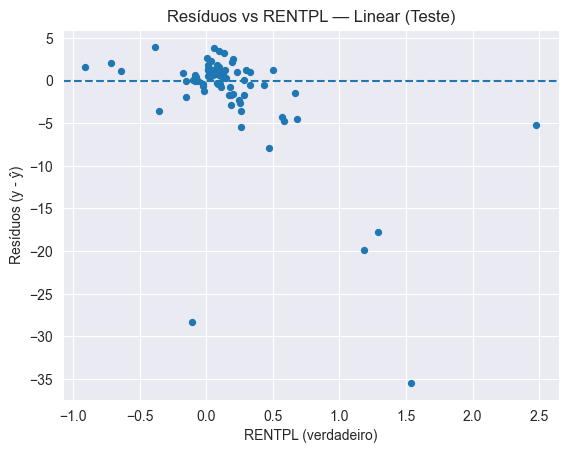

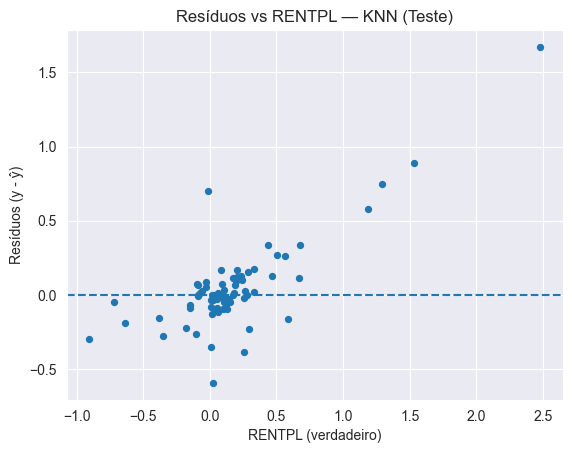

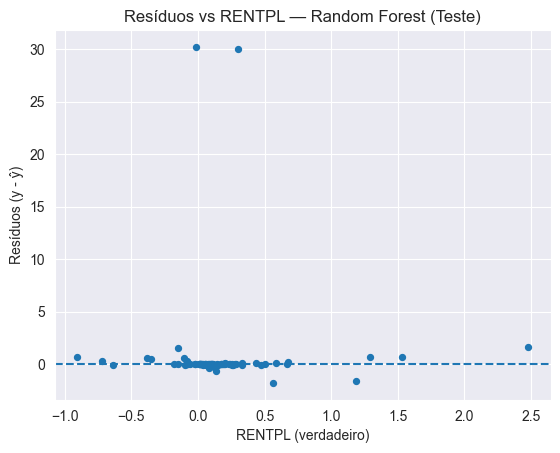

In [54]:

# %% [residuals]
def plot_residuals(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure()
    plt.scatter(y_true, residuals, s=18)
    plt.axhline(0, linestyle='--')
    plt.xlabel("RENTPL (verdadeiro)")
    plt.ylabel("Resíduos (y - ŷ)")
    plt.title(title)
    plt.show()

# Usar base de teste para os gráficos (poderia repetir para treino)
plot_residuals(y_test, yhat_te_lin, "Resíduos vs RENTPL — Linear (Teste)")
plot_residuals(y_test, yhat_te_knn, "Resíduos vs RENTPL — KNN (Teste)")
plot_residuals(y_test, yhat_te_rf,  "Resíduos vs RENTPL — Random Forest (Teste)")


## 9) (6) Melhor modelo — justificativa

In [55]:

# %% [best]
# Critério: menor RMSE na base de TESTE (principal), desempate por MAE e R2 maior
comp_te = comp[comp['Base']=='Teste'].copy()
comp_te = comp_te.sort_values(['RMSE','MAE', 'R2'], ascending=[True, True, False])
melhor_modelo = comp_te.iloc[0]['Modelo']
print("Ranking (Teste):")
display(comp_te.reset_index(drop=True))
print(f"Melhor modelo (critério: RMSE menor em Teste): {melhor_modelo}")


Ranking (Teste):


,Modelo,Base,RMSE,R2,MAE
0,KNN,Teste,0.299458,0.555619,0.164320
1,RF,Teste,4.939346,-119.899153,0.991783
2,Linear,Teste,6.455963,-205.541044,2.936136


Melhor modelo (critério: RMSE menor em Teste): KNN
